- stacked chart of player origin
- histogram of elo in a tournament
- histogram of playing time (need to transfer from string first)


In [1]:
import bga_function  #(self-made functions)
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import statistics
import datetime
import re
import pandas as pd
import numpy as np
import holoviews as hv
import hvplot.pandas # adds hvplot method to pandas objects
from selenium.webdriver.common.action_chains import ActionChains
from contextlib import redirect_stdout
from bokeh.plotting import show
from bokeh.io import export_png
import os

# from selenium.webdriver.chrome.options import Options

waiting_time = 5

In [2]:
# service = webdriver.FirefoxService(executable_path = r'C:\Users\Simon\app\bin\geckodriver.exe')
# driver = webdriver.Firefox(service=service)
# "C:\Users\Simon\Documents\GitHub\wpoc\code\chromedriver.exe"
service = webdriver.ChromeService(executable_path = r'C:\Users\Simon\Documents\GitHub\wpoc\code\chromedriver.exe')
driver = webdriver.Chrome(service=service)
# # log-in  qxxxaxxx 1xxx1xxx 
driver.get("https://en.boardgamearena.com/account")
time.sleep(5)

In [3]:
clickable1 = driver.find_element(By.ID, "username_input")
ActionChains(driver)\
        .click(clickable1)\
        .send_keys("simbkt")\
        .perform()

clickable2 = driver.find_element(By.ID, "password_input")
ActionChains(driver)\
        .click(clickable2)\
        .send_keys("qwerasdf")\
        .perform()

time.sleep(3)
clickable3 = driver.find_element(By.ID, "submit_login_button")
ActionChains(driver)\
        .click(clickable3)\
        .perform()

time.sleep(waiting_time)

### Scrap tournament page: get game name, user name and link, match link


In [4]:
# get url of this tournament
tournament_link = driver.current_url

# get tournament name
tournament_name = driver.find_element(By.CLASS_NAME, 'tournaments-presentation__title-tournament').text
print(tournament_name)

# get game name
game_name = driver.find_element(By.CLASS_NAME, 'tournaments-presentation__title-game').find_element(By.CLASS_NAME, 'bga-link').text
print(game_name)
print(tournament_link)

# get start date
start_date = driver.find_element(By.CLASS_NAME, 'localDate').text[:10]

# get lists of names and link from the  tournament page
entries_finished_tournament = driver.find_elements(By.CLASS_NAME, 'tournaments-results-players__name')
# entries_ongoing_tournament = driver.find_elements(By.CLASS_NAME, 'tournaments-registered-players__name')
preliminary_entries = driver.find_elements(By.CLASS_NAME, 'tournaments-registered-players__player ')

entries_ongoing_tournament = []
for i in preliminary_entries:
    if i.find_element(By.CLASS_NAME, 'tournaments-registered-players__rank').text == 'invited':
        pass
    else:
        entries_ongoing_tournament.append(i.find_element(By.CLASS_NAME, 'tournaments-registered-players__name'))

# get rank of players
if game_name == '7 Wonders':
    top_rank_class = ['tournaments-results-players__player--rank1',
                      'tournaments-results-players__player--rank2',
                      'tournaments-results-players__player--rank3',
                      'tournaments-results-players__player--rank4',
                      'tournaments-results-players__player--rank5',
                      'tournaments-results-players__player--rank6',
                      'tournaments-results-players__player--rank7',
                      'tournaments-results-players__player--rank8']
else:
    top_rank_class = ['tournaments-results-players__player--rank1','tournaments-results-players__player--rank2','tournaments-results-players__player--rank3','tournaments-results-players__player--rank5']

ranked_player = []
for i in top_rank_class:
    # print(i)
    entries = driver.find_elements(By.CLASS_NAME, i)
    for _ in entries:
        result = re.findall("(.*)\n(.*)",_.text)
        link = _.find_element(By.CLASS_NAME, "playername").get_attribute('href')
        ranked_player.append([result,link])
    
players=[]
player_links=[]
tables=[]

# print results while running
for i in entries_finished_tournament + entries_ongoing_tournament:
    # print(i.text, i.get_attribute("href"))
    players.append(i.text)
    player_links.append(i.get_attribute("href"))

print("")   
print(f"number of players: {len(players)}") 
print("")
if driver.find_element(By.CLASS_NAME,'tournaments-mode-presentation__name').text !='Groups Stage':
    entries_table = driver.find_elements(By.CLASS_NAME, 'v2tournament__encounter-title')
    for i in entries_table:
        # print(i.get_attribute("href"))
        if i.text == 'Skipped': # dont include ongoing tables
            # print("skipped")
            pass
        else:
            tables.append(i.get_attribute("href"))
else: # group stage tournament 
    group_page_link = []
    for i in driver.find_elements(By.CLASS_NAME,'v2tournament__encounter-title'):
        group_page_link.append(i.get_attribute("href"))
    for link in group_page_link:
        if re.search("tournament",link): # stage 1 group link
            print("look into the page of a group...")
            driver.get(link)
            time.sleep(waiting_time)
            entries_table = driver.find_elements(By.CLASS_NAME, 'v2tournament__encounter-title')
            for i in entries_table:
                if i.text == 'Skipped': # dont include ongoing tables
                    # print("skipped")
                    pass
                else:
                    tables.append(i.get_attribute("href")) 
        else: # stage 2 elimination table links
            tables.append(link)     
            
print("")
tables_bk = tables
tables = list(filter(None, tables)) # get rid of entries of skipped tables
print("number of tables:", len(tables))

interrupt = -1


Western Pacific Ocean Cup • Season 2
Splendor
https://boardgamearena.com/tournament?id=308419

number of players: 70

look into the page of a group...
look into the page of a group...

number of tables: 211


## Scrap user page: retrun the information of users


In [5]:
# diagnosis code when interrupted
interrupt += 1
if interrupt == 0: # command to start new task
    pass
else:
    pos = len(player_info) 
    print("number of iteration left: ",len(players)-pos)
    waiting_time += 1

In [6]:
# estimate script running time
scrip_player_duration = len(players) * waiting_time * 1.43    #tried 1.4 1.5 1.45 1.43 
script_player_time = datetime.datetime.now() + datetime.timedelta(seconds=scrip_player_duration)
print(f"estimate to finish scraping players at {script_player_time.strftime('%H:%M')}")

# visit every user page
if interrupt == 0: # command to start new task
    player_info = []
    for i in range(len(players)): # loop into each player's user page
        player_info.append(bga_function.get_player_info(driver, waiting_time, player_links[i], game_name))
else: # command when interrupt
    for i in range(pos, len(players)): # when interrupt
        player_info.append(bga_function.get_player_info(driver, waiting_time, player_links[i], game_name))

print(f"finish scraping players at {datetime.datetime.now().strftime('%H:%M')}")    

estimate to finish scraping players at 21:51
finish scraping players at 21:51


In [7]:
print("number of iteration left: ",len(players) - len(player_info) )

number of iteration left:  0


In [30]:
# extract needed information
countries = []
elos = []
languages = []
reputations = []
# read the data
for i in player_info:
    if i[0] == '':
        pass
    else:
        countries.append(i[1].split(",")[0])
        elos.append(i[2])
        languages.append(i[3])
        reputations.append(i[4])
# get Q1, Q2,Q3
elos = [int(i) for i in elos] # convert string to value  in elos
elo_q1 = int(np.quantile(elos, .25))
elo_q2 = int(np.quantile(elos, .5))
elo_q3 = int(np.quantile(elos, .75))

# get top origins of players
top_countries = (pd.DataFrame(countries).value_counts() /len(countries) *100).astype('int').astype('str') +'%'

# make plot of elo distribution
df1 = pd.DataFrame(elos, columns=['elo'])
df1['dummy'] = 1
plot = hv.BoxWhisker(df1, vdims='elo')  * df1.hvplot.scatter(y='elo' ,x = 'dummy', c='orange', size = 5).opts(jitter=0.3)
plot.opts(invert_axes=True, height = 70, width=350, xlabel='',ylabel='', title ='Elo of players',yaxis = None, fontsize={'title': 11})
fig = hv.render(plot)
fig.outline_line_width = 0
fig.toolbar.autohide = True
show(fig)
# save into png and make transparent background
elo_file = '../assets/images/' + game_name + tournament_name +"_Elo_" + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png'
export_png(fig, filename = elo_file)
print('output image:', elo_file)

transformed_elo_file = bga_function.transparent_background(elo_file)
os.remove(elo_file)

# list local origins
watch_list =['South Korea','North Korea','Japan',
             'China','Hong Kong','Macao','Taiwan',
             'Singapore','Viet Nam','Thailand','Indonesia','Malaysia','Philippines','Myanmar','Cambodia',
             'India','Bangladesh','Pakistan',
             'Kazakhstan','Mongolia','Georgia',
             'Australia','New Zealand','Palau']
index_list = []
index = 0
for i in countries:
    if i in watch_list:
        # print(count,i)
        index_list.append(index)
    else:
        pass
    index +=1
    
# list information
with open(game_name + ' - ' +tournament_name + '.txt', "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        print("---LocalPlayer---\n")
        for i in index_list:
            print(players[i])
        print("\n- Reputations:\n")
        for i in index_list:
            print(reputations[i])
        print("\n\n---link of user page---\n")
        for i in index_list:
            print(player_links[i])
        print("\n---Origin---\n")
        for i in index_list:
            print(countries[i])
            # print("\n")
        print("\n---Language---\n")
        for i in index_list:
            print(', '.join(languages[i]))
            # print("\n")
        print("\n\n- Origins of players:\n")
        print(top_countries)
        print("\n\n\n- Q1/Q2/Q3 of player's Elo rating:\n")
        print(f"{elo_q1}/{elo_q2}/{elo_q3}")
f.close()

### finish scraping player data
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
time.sleep(waiting_time)
interrupt = -1


output image: ../assets/images/SplendorWestern Pacific Ocean Cup • Season 2_Elo_20240907223829.png


FileNotFoundError: [Errno 2] No such file or directory: '../assets/t_images/SplendorWestern Pacific Ocean Cup • Season 2_Elo_20240907223829.png'

## read the list of tables, return table duration and slow players:

In [9]:
interrupt = -1

In [10]:
### diagnosis code when interrupted
interrupt += 1
if interrupt == 0: # command to start new task
    pass
else:
    pos = len(table_info) 
    print("number of iteration left: ",len(tables)-pos)
    waiting_time += 1

# pos +=1
# # interrupt = 1
# # pos = len(table_info)
# # print(pos-1, table_info[-1], "\n")
# # print("number of iteration left: ",len(tables))
# for x in range(pos-2, len(tables)):
#   print(x, tables[x])



In [11]:
# loop into all tables

# estimate time
# waiting_time = 15
scrip_table_duration = len(tables) * waiting_time * 1.5
script_table_time = datetime.datetime.now() + datetime.timedelta(seconds=scrip_table_duration)
print(f"estimate to finish scraping tables at {script_table_time.strftime('%H:%M')}")

# >>>>> when scraping for the first time
if interrupt == 0:
    table_info = []
    for i in range(len(tables)):
        table_info.append(bga_function.get_table_info(driver, waiting_time,tables[i]))
else: 
# >>>>> when interrupt
    for i in range(pos, len(tables)): 
        table_info.append(bga_function.get_table_info(driver, waiting_time,tables[i]))


estimate to finish scraping tables at 22:18


In [12]:
print("number of iteration left: ",len(tables)-len(table_info))


number of iteration left:  0


In [13]:
# list players that is either too slow or leave the game intentionly
black_list = []
for i in table_info:
    if i[3] != '': # leave or kicked
        black_list.append(i[3]) 
    elif i[4] != '':  # didnt finish on time
        black_list.append(i[4]) 
    
    
# append the black list to the file
f = open(game_name + ' - ' +tournament_name + '.txt', "a", encoding='utf-8')
f.write("\n---BlackList---\n\n") 
for i in black_list:
    f.write(i)
    f.write("\n")
f.close()

In [14]:
# statistics"""'
number_tables = len(tables)
ratio_cancelled_tables = 0
for i in range(len(table_info)):
    # print(table_info[i][0])
    ratio_cancelled_tables += 1/number_tables if table_info[i][0] == 'cancelled' else 0

ratio_abandoned_tables = 0
for i in range(len(table_info)):
    ratio_abandoned_tables +=1/number_tables if table_info[i][0] == 'abandoned' else 0    
    
table_times = []
for i in range(len(table_info)):
    table_times.append(table_info[i][1])

# create df with player name and time spent
df = pd.DataFrame(columns = ['Player', 'Used_time'])
for i in range(len(table_info)):
    players_time = table_info[i][2] 
    for i in players_time:
        dict = {'Player':[i[0]], 
                'Used_time':[i[1]] 
               } 
        df_add = pd.DataFrame(dict) 
        df = pd.concat([df, df_add], ignore_index = True) 


# convert the unit of duration into days
converted_table_times = bga_function.time_converstion(table_times)

# spread statistics
median_duration = round(statistics.median(converted_table_times),1)
duration_q1 = (np.quantile(converted_table_times, .25))
duration_q2 = (np.quantile(converted_table_times, .5))
duration_q3 = (np.quantile(converted_table_times, .75))
print("Q1/Q2/Q3 quantile of time: ", duration_q1,duration_q2,duration_q3)

f = open(game_name + ' - ' +tournament_name + '.txt', "a", encoding='utf-8')
f.write("\n-----\nQ1/Q2/Q3 quantile of time: \n")
f.write(str(duration_q1) + ", "+str(duration_q2) + ", "+ str(duration_q3)) 
f.write("\n")
f.close()


Q1/Q2/Q3 quantile of time:  1.1 2.55 4.0


In [15]:
# plot
from bokeh.plotting import show
from bokeh.io import export_png

df2 = pd.DataFrame(converted_table_times, columns=['tt'])
df2['dummy'] = 1
plot = hv.BoxWhisker(df2, vdims='tt')  * df2.hvplot.scatter(y='tt' ,x = 'dummy', c='orange', size=5).opts(jitter=0.3)
plot.opts(invert_axes=True, height = 70, width=350, xlabel='',ylabel='', yaxis=None, title='Table duration (days)',fontsize={'title': 11})
fig = hv.render(plot)
fig.outline_line_width =0
fig.toolbar.autohide = True
show(fig)

# save into png and make transparent background
duration_file = '../assets/images/'+ game_name + tournament_name + "_Duration_" +time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png'
export_png(fig, filename=duration_file)
print('output image:', duration_file)
transformed_duration_file = bga_function.transparent_background(duration_file)
os.remove(duration_file)



output image: ../assets/SplendorWestern Pacific Ocean Cup • Season 2_Duration_20240907221658.png
output image: ../assets/t_SplendorWestern Pacific Ocean Cup • Season 2_Duration_20240907221658.png


In [21]:
### finish table part
print(f"- Abandoned tables (reached duration limit): {ratio_abandoned_tables:.0%}")
print(f"- Cancelled tables (player left or got kicked): {ratio_cancelled_tables:.0%}")
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
time.sleep(waiting_time)

- Abandoned tables (reached duration limit): 10%
- Cancelled tables (player left or got kicked): 9%
2024-09-07 22:24:37


## summary

In [27]:
# summary message
print(f"- [{tournament_name.replace("Western Pacific Ocean Cup • ","")}]({tournament_link})")
print("- Date:",start_date, "- __/__/2024") #put this manually 
print('- Number of players:', len(players))
print("- Top origins of players:",top_countries.index[0][0], f"{top_countries.iloc[0]}", top_countries.index[1][0], f"{top_countries.iloc[1]}", top_countries.index[2][0], f"{top_countries.iloc[2]}", top_countries.index[3][0], f"{top_countries.iloc[3]}", top_countries.index[4][0], f"{top_countries.iloc[4]}") 
print(f"- Abandoned tables (reached duration limit): {ratio_abandoned_tables:.0%}")
print(f"- Cancelled tables (player left or got kicked): {ratio_cancelled_tables:.0%}")
print("- Q1/Q2/Q3 of player's Elo rating:", f"{elo_q1}/{elo_q2}/{elo_q3}")
print("- Q1/Q2/Q3 of table duration (days):", f"{round(duration_q1,1)}/{round(duration_q2,1)}/{round(duration_q3,1)}") #put this later 
print('- Winners:', f"\U0001F947{players[0]}", f"\U0001F948{players[1]}", f"\U0001F949{players[2]}")
print("- Winners(meta event points):", 
    f'{ranked_player[0][0][0][0]}(100);', 
    f'{ranked_player[1][0][0][0]}(75);',
    f'{ranked_player[2][0][0][0]}(50);',
    f'{ranked_player[3][0][0][0]}(50);',
    f'{ranked_player[4][0][0][0]}(10);',    
    f'{ranked_player[5][0][0][0]}(10);',
    f'{ranked_player[6][0][0][0]}(10);',
    f'{ranked_player[7][0][0][0]}(10)',)

# image links
print("")
print('<div>')
print(' <img src="/wpoc/assets/images/tournament/', re.findall('assets/(.*)',transformed_elo_file)[0],'" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px; margin-top:-15px"/>', sep='')
print('</div>')
print('<div>')
print(' <img src="/wpoc/assets/images/tournament/', re.findall('assets/(.*)',transformed_duration_file)[0],'" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px;"/>', sep='')
print('</div>')
# print("")
print('<p>&nbsp;</p>')


# Things to check manually
print("\n\n1. check last day of tournament from the tournament page")
print("2. change the 4th player point to 25")
print("update Region standings")




- [Season 2](https://boardgamearena.com/tournament?id=308419)
- Date: 07/22/2024 - __/__/2024
- Number of players: 70
- Top origins of players: Japan 14% China 10% Taiwan 10% Hong Kong 7% Thailand 5%
- Abandoned tables (reached duration limit): 10%
- Cancelled tables (player left or got kicked): 9%
- Q1/Q2/Q3 of player's Elo rating: 176/279/399
- Q1/Q2/Q3 of table duration (days): 1.1/2.6/4.0
- Winners: 🥇bousi 🥈arno c r 🥉hakomugiko
- Winners(meta event points): bousi(100); arno c r(75); hakomugiko(50); gobasak(50); jog-tw(10); o0O KAASKOP O0o(10); akkyu39(10); yui05163(10)

<div>
 <img src="/wpoc/assets/images/tournament/t_SplendorWestern Pacific Ocean Cup • Season 2_Elo_20240907215156.png" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px; margin-top:-15px"/>
</div>
<div>
 <img src="/wpoc/assets/images/tournament/t_SplendorWestern Pacific Ocean Cup • Season 2_Duration_20240907221658.png" width="300" style="display: block; margin-left: 30px; margin-bottom: 5px;"/

# Player_ranking

In [26]:
# add region information to ranked players
for item in ranked_player:
    player_region = bga_function.get_player_info(driver, waiting_time, item[1], game_name)[1]
    item.append(player_region)
    

In [28]:
print("2. paste information below to csv:")
print(">>\n")
        # countries.append(i[1].split(",")[0])

for item in ranked_player:
    # print(item[0][0][1])
    # print(game_name,",", tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,item[0][0][0], ",", item[2],",",item[0][0][1], sep='')    
    print(game_name,",", 
          tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,
          item[0][0][0], ",", 
          item[2].split(",")[0],",",
          item[0][0][1].replace("1st", "100").replace("2nd", "75").replace("3rd", "50").replace("4th", "25") \
          .replace("5th", "10").replace("6th", "10").replace("7th", "10").replace("8th", "10"), 
          sep='')    

# for item in ranked_player:
#     print("All Games",",", tournament_name.replace("Western Pacific Ocean Cup • ",""),"," ,item[0][0][0], ",", item[2],",", item[0][0][1], sep='')


2. paste information below to csv:
>>

Splendor,Season 2,bousi,Japan,100
Splendor,Season 2,arno c r,France,75
Splendor,Season 2,hakomugiko,Japan,50
Splendor,Season 2,gobasak,South Korea,50
Splendor,Season 2,jog-tw,Taiwan,10
Splendor,Season 2,o0O KAASKOP O0o,Netherlands,10
Splendor,Season 2,akkyu39,Japan,10
Splendor,Season 2,yui05163,Japan,10


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/ForestShuffleRanking.png
Forest Shuffle
🥇Czechia(100) 🥈France(85) 🥉Australia(50)
Region
Czechia        100
France          85
Australia       50
New Zealand     50
Japan           10
Russia          10
Thailand        10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/TickettoRideRanking.png
Ticket to Ride
🥇Netherlands(100) 🥈Hong Kong(95) 🥉Spain(60)
Region
Netherlands    100
Hong Kong       95
Spain           60
France          50
China           10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/7WondersRanking.png
7 Wonders
🥇Belgium(160) 🥈Japan(100) 🥉Poland(85)
Region
Belgium                     160
Japan                       100
Poland                       85
Hong Kong                    75
Hungary                      75
Philippines                  25
Germany                      20
Australia                    10
Italy                        10
Ukraine                      10
United States of America     10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/SplendorRanking.png
Splendor
🥇Japan(345) 🥈France(75) 🥉China(70)
Region
Japan          345
France          75
China           70
Hong Kong       50
South Korea     50
Netherlands     20
Canada          10
Taiwan          10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/WingspanRanking.png
Wingspan
🥇United States of America(160) 🥈Australia(100) 🥉Hong Kong(100)
Region
United States of America    160
Australia                   100
Hong Kong                   100
Peru                         60
France                       50
Kazakhstan                   50
Taiwan                       50
Belgium                      10
China                        10
Hungary                      10
Mexico                       10
Ukraine                      10
Viet Nam                     10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/KingdominoRanking.png
Kingdomino
🥇Poland(200) 🥈Spain(100) 🥉Canada(85)
Region
Poland                      200
Spain                       100
Canada                       85
United States of America     75
France                       60
New Zealand                  50
Switzerland                  20
Australia                    10
Greece                       10
Japan                        10
Taiwan                       10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/CarcassonneRanking.png
Carcassonne
🥇Philippines(150) 🥈Mexico(100) 🥉Taiwan(100)
Region
Philippines            150
Mexico                 100
Taiwan                 100
Japan                   85
Thailand                75
Argentina               50
Antigua and Barbuda     10
Australia               10
Brazil                  10
Chile                   10
Poland                  10
Spain                   10
Ukraine                 10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/AzulRanking.png
Azul
🥇China(245) 🥈France(110) 🥉Philippines(100)
Region
China          245
France         110
Philippines    100
Japan           85
Australia       70
Italy           10
Thailand        10
Name: MetaPoint, dtype: int64


C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/AllGamesRanking.png
All Games
🥇Japan(635) 🥈France(430) 🥉China(335)
Region
Japan                       635
France                      430
China                       335
Hong Kong                   320
Poland                      295
Philippines                 275
Australia                   250
United States of America    245
Spain                       170
Belgium                     170
Taiwan                      170
Netherlands                 120
Mexico                      110
New Zealand                 100
Czechia                     100
Thailand                     95
Canada                       95
Hungary                      85
Peru                         60
Argentina                    50
South Korea                  50
Kazakhstan                   50
Ukraine                      30
Italy                        20
Switzerland                  20
Germany                      20
Antigua and Barbuda          10
Russia                       10
Greec

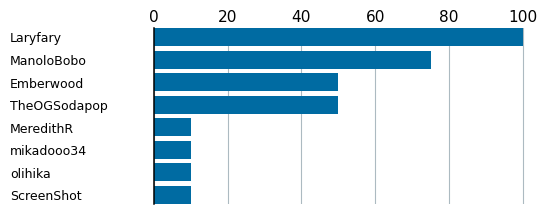

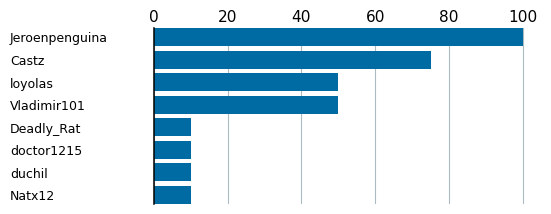

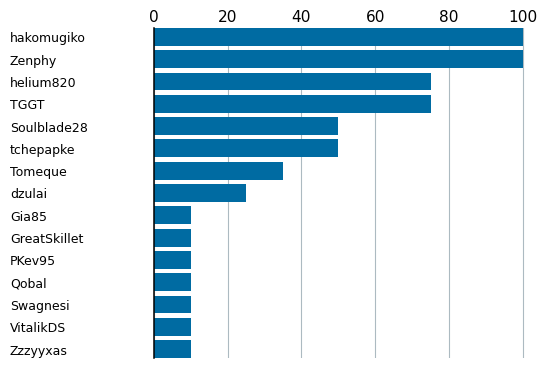

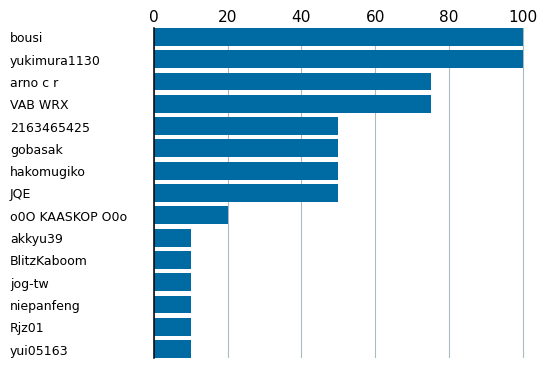

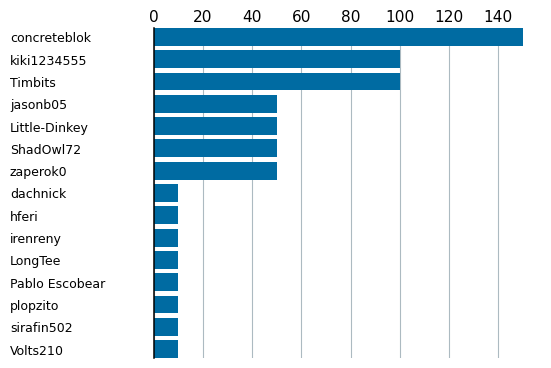

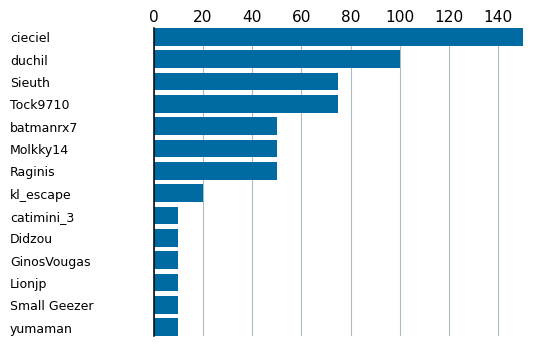

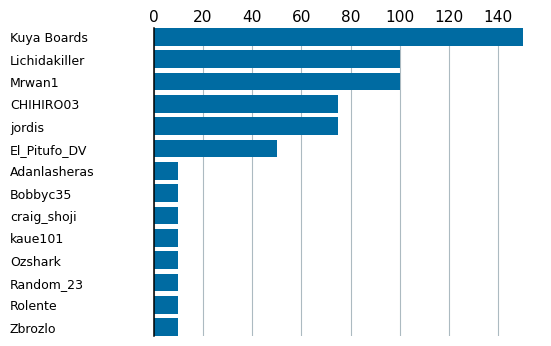

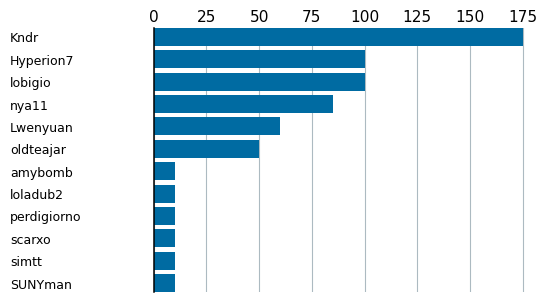

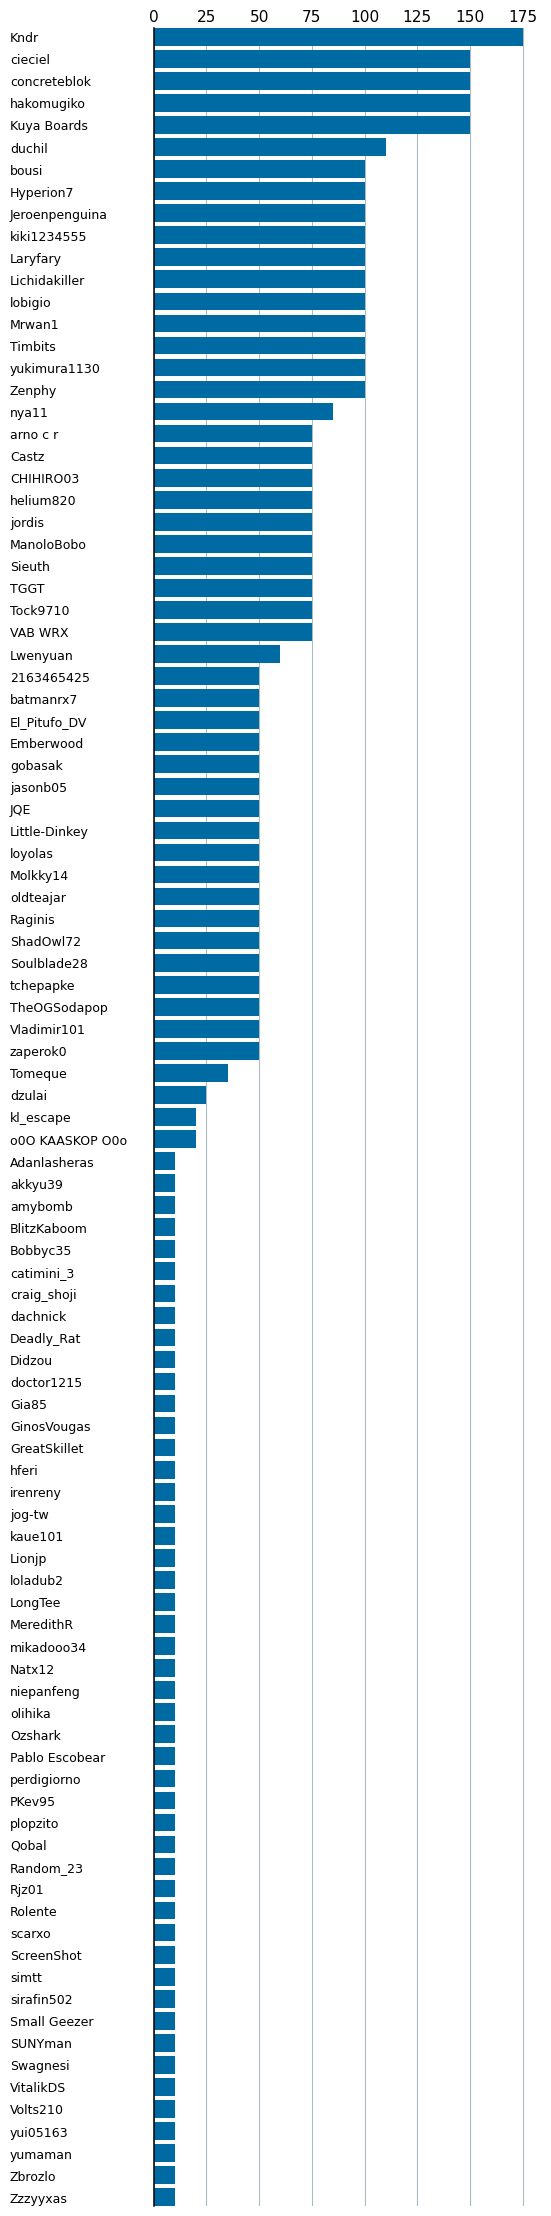

In [29]:
# after update the csv file, output the graph
import bga_function  #(self-made functions)
import time

for GameName in ['Forest Shuffle','Ticket to Ride', '7 Wonders','Splendor', 'Wingspan', 'Kingdomino','Carcassonne', 'Azul','All Games']:
    # bga_function.PlayerRankingChart(GameName)
    bga_function.PlayerRankingChart(GameName)

    time.sleep(5)

C:\Users\Simon\Documents\GitHub\wpoc\code\bga_function.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(selected_data['PlayerName'],      # Set labels again


../assets/images/ranking/AllGamesRanking.png
All Games
🥇Japan(355) 🥈China(335) 🥉Philippines(275)
Region
Japan                       355
China                       335
Philippines                 275
France                      270
Hong Kong                   245
United States of America    235
Poland                      220
Australia                   200
Spain                       170
Belgium                     160
Taiwan                      160
Mexico                      110
Netherlands                 110
Canada                       95
Hungary                      85
Thailand                     85
Peru                         60
Kazakhstan                   50
New Zealand                  50
Argentina                    50
Ukraine                      20
Italy                        20
Switzerland                  20
Antigua and Barbuda          10
Greece                       10
Germany                      10
Chile                        10
Brazil                       10


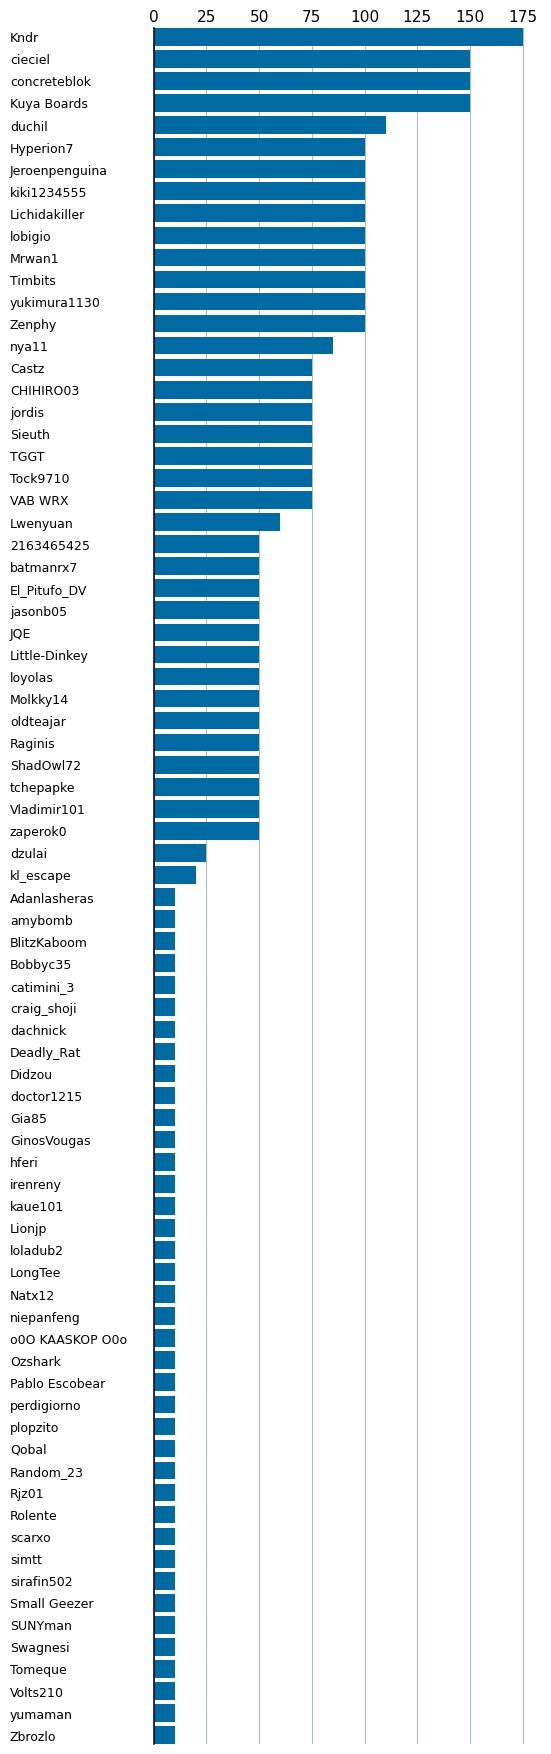

In [1]:
# import bga_function
# bga_function.PlayerRankingChart('All Games')


### possible new features


In [49]:
    game_data = data[data['game'] == GameName].sort_values(by='point', ascending=True)
    acc_game_data = game_data.groupby('player')['point'].sum().sort_values(ascending=False)